# **E2E Data-to-Text: EDA → T5 Generation → Evaluation**

- **Subject:** Generative AI  
- **Student 1:** Alireza MIRZADEH  
- **Student 2:** Austin TANGBAN  
- **Student 3:** Muhammad TAYYAB
- **Submitted to:** Prof. Claire Gardent

This notebook includes:  

0) Installation and imports
1) Data pre-processing
2) A quick EDA of the E2E test split
3) T5-small fine-tuning + CTranslate2 generation
4) Baseline Evaluation Without Prompt Finetuning
5) T5-small fine-tuning with adding intruct + CTranslate2 generation
6) Instruted model Evaluation With Prompt Finetuning
7) Comparative Analysis

# 0) Installation and imports

In [3]:
! pip install transformers[torch] datasets==3.6.0 evaluate ctranslate2 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.8/38.8 MB 21.3 MB/s eta 0:00:00


In [4]:
import datasets
import transformers
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import Trainer, TrainingArguments
import torch
import evaluate
import ctranslate2
from tqdm.notebook import tqdm
import pandas as pd
import json

In [ ]:
# T5 small model with its tokenizer
tokenizer = AutoTokenizer.from_pretrained("google-t5/t5-small")
model = AutoModelForSeq2SeqLM.from_pretrained("google-t5/t5-small")

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [5]:
# Gem/ete_nlg dataset
ds = datasets.load_dataset("GEM/e2e_nlg")

README.md: 0.00B [00:00, ?B/s]

e2e_nlg.py: 0.00B [00:00, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

The repository for GEM/e2e_nlg contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/GEM/e2e_nlg.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/33525 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1484 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1847 [00:00<?, ? examples/s]

Generating challenge_train_sample split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating challenge_validation_sample split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating challenge_test_scramble split:   0%|          | 0/500 [00:00<?, ? examples/s]

# 1) Data pre-processing

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['gem_id', 'gem_parent_id', 'meaning_representation', 'target', 'references'],
        num_rows: 33525
    })
    validation: Dataset({
        features: ['gem_id', 'gem_parent_id', 'meaning_representation', 'target', 'references'],
        num_rows: 1484
    })
    test: Dataset({
        features: ['gem_id', 'gem_parent_id', 'meaning_representation', 'target', 'references'],
        num_rows: 1847
    })
    challenge_train_sample: Dataset({
        features: ['gem_id', 'gem_parent_id', 'meaning_representation', 'target', 'references'],
        num_rows: 500
    })
    challenge_validation_sample: Dataset({
        features: ['gem_id', 'gem_parent_id', 'meaning_representation', 'target', 'references'],
        num_rows: 500
    })
    challenge_test_scramble: Dataset({
        features: ['gem_id', 'gem_parent_id', 'meaning_representation', 'target', 'references'],
        num_rows: 500
    })
})

In [ ]:
# Train dataset example
ds['train'][0]

{'gem_id': 'e2e_nlg-train-0',
 'gem_parent_id': 'e2e_nlg-train-0',
 'meaning_representation': 'name[The Eagle], eatType[coffee shop], food[Japanese], priceRange[less than £20], customer rating[low], area[riverside], familyFriendly[yes], near[Burger King]',
 'target': 'The Eagle is a low rated coffee shop near Burger King and the riverside that is family friendly and is less than £20 for Japanese food.',
 'references': []}

In [ ]:
# Test dataset example
ds['test'][0]

{'gem_id': 'e2e_nlg-test-0',
 'gem_parent_id': 'e2e_nlg-test-0',
 'meaning_representation': 'eatType[pub], food[Fast food], customer rating[high], area[riverside], familyFriendly[no], near[Café Rouge]',
 'target': 'The Mills is not kid friendly as it is a riverside pub near Café Rouge.  Its mid priced fast food is highly rated.',
 'references': ['The Mills is not kid friendly as it is a riverside pub near Café Rouge.  Its mid priced fast food is highly rated.']}

In [6]:
# Keep the columns need fro fine-tuning
columns_to_keep_train_val = ['meaning_representation', 'target']

# Prepare train set
train_dataset = ds['train'].remove_columns(
    [col for col in ds['train'].column_names if col not in columns_to_keep_train_val]
)

# Prepare validation set
validation_dataset = ds['validation'].remove_columns(
    [col for col in ds['validation'].column_names if col not in columns_to_keep_train_val]
)

# Keep the columns need for Evaluation
columns_to_keep_test = ['meaning_representation', 'target', 'references']
# Prepare test set
test_dataset = ds['test'].remove_columns(
    [col for col in ds['test'].column_names if col not in columns_to_keep_test]
)


In [7]:
# Making dataset Dict
processed_dataset = datasets.DatasetDict({
    'train': train_dataset,
    'validation': validation_dataset,
    'test': test_dataset
})

In [8]:
# Rename columns
processed_dataset = processed_dataset.rename_column("meaning_representation", "input_text")
processed_dataset = processed_dataset.rename_column("target", "labels")

In [9]:
processed_dataset

DatasetDict({
    train: Dataset({
        features: ['input_text', 'labels'],
        num_rows: 33525
    })
    validation: Dataset({
        features: ['input_text', 'labels'],
        num_rows: 1484
    })
    test: Dataset({
        features: ['input_text', 'labels', 'references'],
        num_rows: 1847
    })
})

# 2) Exploratory Data Analysis (EDA)

### Dataset head

In [ ]:
#  Dataset head
import pandas as pd

# Convert test split to pandas DataFrame
df_head = processed_dataset["test"].to_pandas().copy()

# Showing only the key columns for clarity
df_head = df_head[["input_text", "labels"]]

print("Sample of Test Dataset (first 10 rows)")
display(df_head.head(10))

Sample of Test Dataset (first 10 rows)


,input_text,labels
0,"eatType[pub], food[Fast food], customer rating...",The Mills is not kid friendly as it is a river...
1,"eatType[pub], food[Japanese], priceRange[moder...","The Wrestlerss is rated 5 out of 5, serving Ja..."
2,"eatType[restaurant], food[Chinese], priceRange...",In the riverside area near the All Bar One the...
3,"name[Blue Spice], eatType[coffee shop], area[c...",A coffee shop in the city centre area called B...
4,"name[Blue Spice], eatType[coffee shop], area[r...",There is a coffee shop Blue Spice in the river...
5,"name[Blue Spice], eatType[coffee shop], custom...",The coffee shop Blue Spice is based near Crown...
6,"name[Blue Spice], eatType[coffee shop], custom...",Burger King is near the coffee shop Blue Spice...
7,"name[Blue Spice], eatType[coffee shop], custom...",Crowne Plaza Hotel has a coffee shop nearby wi...
8,"name[Blue Spice], eatType[pub], area[city centre]",A pub in the city centre area called Blue Spice.
9,"name[Blue Spice], eatType[pub], area[riverside]",There is a pub Blue Spice in the riverside area.


### Distribution of number of slots per MR

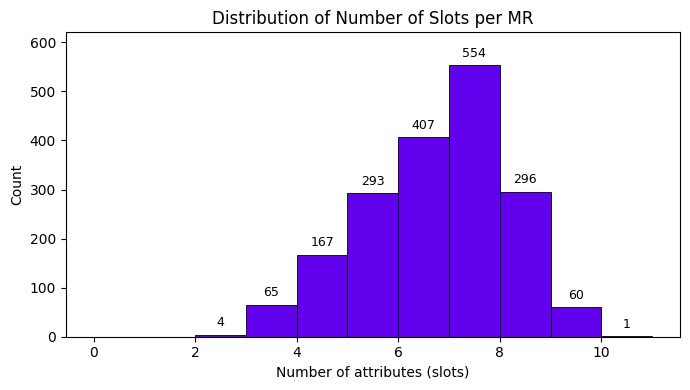

In [ ]:
#  Distribution of number of slots per MR (uses processed_dataset['test']['input_text'])
import re
import pandas as pd
import matplotlib.pyplot as plt

# Matrial Design colors
md_colors = ["#6200EE", "#03DAC6", "#FF0266", "#FFB300", "#018786", "#2962FF", "#00C853", "#AA00FF"]

# 1) Put test split into a DataFrame with the MR text
eda_df = processed_dataset["test"].to_pandas().copy()
eda_df["input_text"] = eda_df["input_text"].astype(str).fillna("")

# 2) Extract (key, value) pairs from input_text like: eatType[pub], food[Fast food]
mr_kvs = eda_df["input_text"].apply(lambda s: re.findall(r'([^,\[]+)\[([^\]]+)\]', s))

# 3) Counting number of slots per MR
eda_df["num_slots"] = mr_kvs.apply(len)

# 4) Ploting histogram with labels
plt.figure(figsize=(7,4))
counts, bins, patches = plt.hist(
    eda_df["num_slots"],
    bins=range(0, eda_df["num_slots"].max() + 2),
    color=md_colors[0],
    edgecolor="black", linewidth=0.6
)
ax = plt.gca()
plt.title("Distribution of Number of Slots per MR")
plt.xlabel("Number of attributes (slots)")
plt.ylabel("Count")

# Add headroom + data labeles above bars
ymax = counts.max() if len(counts) else 0
ax.set_ylim(0, max(1, ymax * 1.12))
offset = max(5, ymax * 0.02)
for i, c in enumerate(counts):
    if c > 0:
        x = bins[i] + (bins[i+1] - bins[i]) / 2
        ax.text(x, c + offset, str(int(c)), ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

### Top 10 most common slot keys in MR

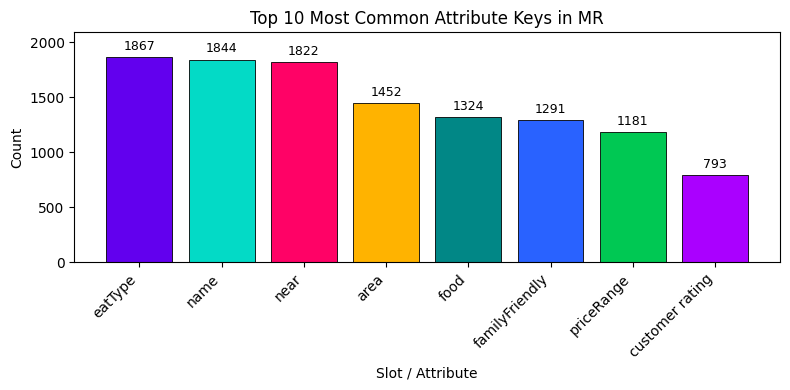

In [ ]:
# Top 10 most common slot keys in MR
from collections import Counter
import matplotlib.pyplot as plt

# 1) Flatten all slot KEYS from the parsed (key, value) list
all_keys = [k.strip() for kvs in mr_kvs for (k, v) in kvs]

# 2) Count and take top 10
key_counts = Counter(all_keys)
top10 = key_counts.most_common(10)
keys, counts = zip(*top10) if top10 else ([], [])

# 3) Bar chart with Material colors + data labels
plt.figure(figsize=(8,4))
ax = plt.gca()
bars = plt.bar(
    range(len(keys)),
    counts,
    color=md_colors[:len(keys)],
    edgecolor="black", linewidth=0.6
)
plt.xticks(range(len(keys)), keys, rotation=45, ha="right")
plt.title("Top 10 Most Common Attribute Keys in MR")
plt.xlabel("Slot / Attribute")
plt.ylabel("Count")

# Headroom + labelings
max_count = max(counts) if len(counts) else 0
ax.set_ylim(0, max(1, max_count * 1.12))
offset = max(5, max_count * 0.02)
for bar in bars:
    y = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, y + offset, int(y), ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

# 3) Baseline : Raw key-value → sentence Tokenizaition and Fine-tuning.

In [ ]:
# Function for Tokenizing the dataset
def tokenize_function(batch):
  model_inputs = tokenizer(batch["input_text"], padding="max_length", truncation=True, max_length=512)
  with tokenizer.as_target_tokenizer():
    labels = tokenizer(batch["labels"], padding="max_length", truncation=True, max_length=512)
  model_inputs["labels"] = labels["input_ids"]
  return model_inputs


In [ ]:
# Tokenizing the dataset
tokenized_dataset = processed_dataset.map(tokenize_function, batched=True)


In [ ]:
# Define the training arguments
training_arguments = transformers.Seq2SeqTrainingArguments(
    output_dir = 't5-small-e2e_nlg',
    num_train_epochs = 3,
    eval_strategy = 'epoch',
    save_strategy='epoch',
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    save_total_limit = 3,
    load_best_model_at_end = True,
    fp16=True,
    optim='adafactor',
    report_to = []
)

In [ ]:
# Fine-tune T5 small model
trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
)

trainer.train()

/tmp/ipython-input-2215721696.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.074000,0.078370
2,0.068400,0.074207
3,0.066100,0.073335


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=6288, training_loss=0.10142879844015185, metrics={'train_runtime': 4377.3727, 'train_samples_per_second': 22.976, 'train_steps_per_second': 1.436, 'total_flos': 1.36120016830464e+16, 'train_loss': 0.10142879844015185, 'epoch': 3.0})

In [ ]:
# Save the fine-tuned model
model.save_pretrained('t5-small-e2e_nlg')

# Save the tokenizer
tokenizer.save_pretrained('t5-small-e2e_nlg')

('t5-small-e2e_nlg/tokenizer_config.json',
 't5-small-e2e_nlg/special_tokens_map.json',
 't5-small-e2e_nlg/spiece.model',
 't5-small-e2e_nlg/added_tokens.json',
 't5-small-e2e_nlg/tokenizer.json')

In [ ]:
!zip -r t5-small-e2e_nlg.zip t5-small-e2e_nlg


In [ ]:
# Load fine-tuned model with the tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained('/content/t5-small-e2e_nlg/t5-small-e2e_nlg')
tokenizer = AutoTokenizer.from_pretrained('/content/t5-small-e2e_nlg/t5-small-e2e_nlg')

In [ ]:
# Test the fine-tuned model with some examples
test_dataset = processed_dataset["test"]
inputs = test_dataset["input_text"][:10]
labels = test_dataset["labels"][:10]

for i in range(len(inputs)):
  input_text = inputs[i]
  target_text = labels[i]

  tokenized_input = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
  output = model.generate(**tokenized_input, max_length=512)
  generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

  print("Input:", input_text)
  print("Target:", target_text)
  print("Generated:", generated_text)
  print("-" * 50)


Input: eatType[pub], food[Fast food], customer rating[high], area[riverside], familyFriendly[no], near[Café Rouge]
Target: The Mills is not kid friendly as it is a riverside pub near Café Rouge.  Its mid priced fast food is highly rated.
Generated: Near Café Rouge in riverside is a fast food pub that is not kid friendly. It has a high customer rating.
--------------------------------------------------
Input: eatType[pub], food[Japanese], priceRange[moderate], customer rating[5 out of 5], area[city centre], near[Raja Indian Cuisine]
Target: The Wrestlerss is rated 5 out of 5, serving Japanese food in a pub. It is higher than average priced, and located near the city centre near Raja Indian Cuisine.
Generated: In the city centre near Raja Indian Cuisine is a pub that serves Japanese food. It has a moderate price range and a customer rating of 5 out of 5.
--------------------------------------------------
Input: eatType[restaurant], food[Chinese], priceRange[high], customer rating[1 out o

## Generation with ctranslate2

In [ ]:
# Convert model to ctranslate format
! ct2-transformers-converter --model /content/t5-small-e2e_nlg/t5-small-e2e_nlg --output_dir t5-small-e2e_nlg-ct2

2025-09-25 11:40:34.873297: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758800434.894921    5578 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758800434.901051    5578 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758800434.915848    5578 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758800434.915892    5578 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758800434.915896    5578 computation_placer.cc:177] computation placer alr

In [ ]:
# Instantiate model as ctranslate Translator and instantiate Tokenizer
translator = ctranslate2.Translator(
    't5-small-e2e_nlg-ct2',
    device='cuda',
)
tokenizer = transformers.AutoTokenizer.from_pretrained('/content/t5-small-e2e_nlg/t5-small-e2e_nlg')

In [ ]:
# Small test data
test_dataset = processed_dataset["test"]
inputs = test_dataset["input_text"][:10]
labels = test_dataset["labels"][:10]


In [17]:
# Define function to pre process inputs
def pre_process(text):
    input_ids = tokenizer.encode(text)
    input_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    return input_tokens

In [18]:
# Define function to post process inputs
def post_process(output):
    output_tokens = output.hypotheses[0]
    output_ids = tokenizer.convert_tokens_to_ids(output_tokens)
    output_text = tokenizer.decode(output_ids, skip_special_tokens=True)
    return output_text

In [19]:
# Generation function
def generation_ct2(inputs, batch_size=32, max_input_length=512, max_decoding_length=512, beam_size=1, length_penalty=1.0, repetition_penalty=1.0):

  batch = [pre_process(text) for text in tqdm(inputs)]

  all_generated = []

  for i in tqdm(range(0, len(batch), batch_size)):
      subbatch = batch[i:i+batch_size]

      # translate_batch expects List[List[str]]
      results = translator.translate_batch(
          subbatch,
          max_batch_size=batch_size,
          beam_size=beam_size,
          max_input_length=max_input_length,
          max_decoding_length=max_decoding_length,
          num_hypotheses=1,
          length_penalty=length_penalty,
          repetition_penalty=repetition_penalty,
      )

      all_generated += [post_process(o) for o in results]

  return all_generated

In [ ]:
# Example test generation
Examples_generated = generation_ct2(inputs)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Checking input vs target vs generated
for i in range(len(inputs)):
  input_text = inputs[i]
  target_text = labels[i]

  print("Input:", input_text)
  print("Target:", target_text)
  print("Generated:", Examples_generated[i])
  print("-" * 50)

Input: eatType[pub], food[Fast food], customer rating[high], area[riverside], familyFriendly[no], near[Café Rouge]
Target: The Mills is not kid friendly as it is a riverside pub near Café Rouge.  Its mid priced fast food is highly rated.
Generated: Near Café Rouge in riverside is a fast food pub that is not kid friendly. It has a high customer rating.
--------------------------------------------------
Input: eatType[pub], food[Japanese], priceRange[moderate], customer rating[5 out of 5], area[city centre], near[Raja Indian Cuisine]
Target: The Wrestlerss is rated 5 out of 5, serving Japanese food in a pub. It is higher than average priced, and located near the city centre near Raja Indian Cuisine.
Generated: In the city centre near Raja Indian Cuisine is a pub that serves Japanese food. It has a moderate price range and a customer rating of 5 out of 5.
--------------------------------------------------
Input: eatType[restaurant], food[Chinese], priceRange[high], customer rating[1 out o

## Full generation on the test set

In [ ]:
test_dataset = processed_dataset["test"]
inputs = test_dataset["input_text"]
labels = test_dataset["labels"]

In [ ]:
full_test_generation = generation_ct2(inputs)

  0%|          | 0/1847 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

In [ ]:
# Check the number of generated text
len(full_test_generation)

1847

In [ ]:
# Prepare for saving result as JSON
gen_json = []
for i in range(len(inputs)):
  gen_json.append({
      "input_text": inputs[i],
      "target": labels[i],
      "generated_text": full_test_generation[i]
  })

In [ ]:
# Save the result
with open("t5-small-e2e_nlg-test-results-3epoch.json", "w") as f:
  json.dump(gen_json, f)

In [ ]:
# Checking the saved result
with open("t5-small-e2e_nlg-test-results-3epoch.json", "r") as f:
  result_json = json.load(f)

In [ ]:
result_json[0]

{'input_text': 'eatType[pub], food[Fast food], customer rating[high], area[riverside], familyFriendly[no], near[Café Rouge]',
 'target': 'The Mills is not kid friendly as it is a riverside pub near Café Rouge.  Its mid priced fast food is highly rated.',
 'generated_text': 'Near Café Rouge in riverside is a fast food pub that is not kid friendly. It has a high customer rating.'}

# 4) Baseline Evaluation

In [ ]:
!pip install -q evaluate sacrebleu bert-score rouge-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.0 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings("ignore", message="Some weights of the model checkpoint at roberta-large")

In [ ]:
# creating a reusable evaluation function: SacreBLEU, ROUGE-L, BERTScore-F1
def run_eval(results_path, title="Evaluation", plot=False,
             bertscore_model="distilbert-base-uncased"): # using distilbert-base-uncased for evaluating purpose
    import json
    import matplotlib.pyplot as plt
    from statistics import mean
    import evaluate

    # colors for visual
    md_colors = ["#6200EE", "#03DAC6", "#FF0266", "#FFB300", "#018786", "#2962FF", "#00C853", "#AA00FF"]

    # loading JSON
    with open(results_path, "r") as f:
        data = json.load(f)
    preds = [d.get("generated_text", "") for d in data]
    refs_single = [d.get("target", "") for d in data]
    refs_listlist = [[r] for r in refs_single]  # for SacreBLEU

    # metrics
    bleu = evaluate.load("sacrebleu").compute(
        predictions=preds, references=refs_listlist
    )["score"]  # 0..100

    rougeL = evaluate.load("rouge").compute(
        predictions=preds, references=refs_single, use_aggregator=True
    )["rougeL"] * 100.0  # scale to %

    bsf1 = mean(evaluate.load("bertscore").compute(
        predictions=preds, references=refs_single, lang="en",
        model_type=bertscore_model, rescale_with_baseline=True
    )["f1"]) * 100.0  # scale to %

    metrics = {
        "SacreBLEU": bleu,
        "ROUGE-L": rougeL,
        "BERTScore-F1": bsf1,
    }

    # single plot
    if plot:
        names = ["SacreBLEU", "ROUGE-L", "BERTScore-F1"]
        vals = [metrics[k] for k in names]
        labels = [f"{v:.2f}%" for v in vals]

        plt.figure(figsize=(7.5, 4.2))
        ax = plt.gca()
        bars = ax.bar(range(len(names)), vals,
                      color=[md_colors[i % len(md_colors)] for i in range(len(names))],
                      edgecolor="black", linewidth=0.8)
        ax.set_xticks(range(len(names))); ax.set_xticklabels(names)
        ax.set_ylabel("Score (scaled to %)"); ax.set_title(title)
        ax.set_xlabel("Evaluation metric"); ax.set_title(title)
        ymax = max(vals) if vals else 1; ax.set_ylim(0, max(5, ymax*1.15))
        for i, b in enumerate(bars):
            h = b.get_height()
            ax.text(b.get_x()+b.get_width()/2, h + ymax*0.02, labels[i],
                    ha="center", va="bottom", fontsize=9)
        plt.tight_layout(); plt.show()

    # print evaluatio numbers
    print("Evaluation numbers for " + title + ": ")
    print(f"SacreBLEU        : {metrics['SacreBLEU']:.2f}")
    print(f"ROUGE-L (F1)     : {metrics['ROUGE-L']/100:.4f}")
    print(f"BERTScore F1     : {metrics['BERTScore-F1']/100:.4f}")
    return metrics


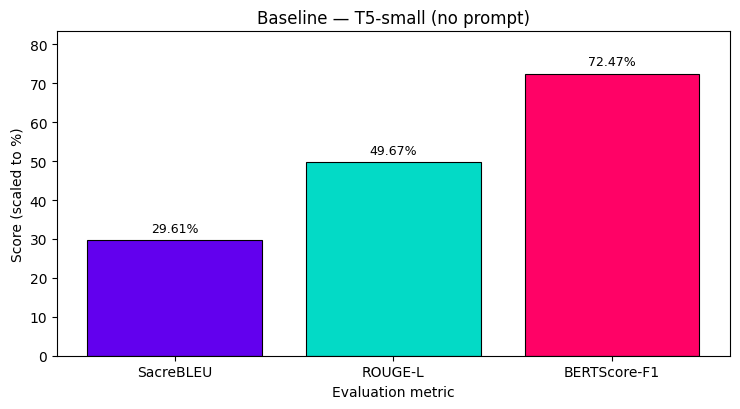

Evaluation numbers for Baseline — T5-small (no prompt): 
SacreBLEU        : 29.61
ROUGE-L (F1)     : 0.4967
BERTScore F1     : 0.7247


In [ ]:
# evaluation Baseline — T5-small (no prompt)
m_base = run_eval(
    "t5-small-e2e_nlg-test-results-3epoch.json",
    title="Baseline — T5-small (no prompt)",
    plot=True
)


# 5) Instruction-Style (Prompt-Based) Fine-Tuning

## Data Preprocessing

In [10]:
# Add intruction prompt to the input_text
def add_instruct(batch):
  prompt = "Convert the following Key-value representation into a natural language sentence: "
  batch["input_text"] = [prompt + x for x in batch["input_text"]]
  return batch


In [11]:
# Apply to all splits
processed_dataset = processed_dataset.map(add_instruct, batched=True)


Map:   0%|          | 0/33525 [00:00<?, ? examples/s]

Map:   0%|          | 0/1484 [00:00<?, ? examples/s]

Map:   0%|          | 0/1847 [00:00<?, ? examples/s]

In [ ]:
processed_dataset

DatasetDict({
    train: Dataset({
        features: ['input_text', 'labels'],
        num_rows: 33525
    })
    validation: Dataset({
        features: ['input_text', 'labels'],
        num_rows: 1484
    })
    test: Dataset({
        features: ['input_text', 'labels', 'references'],
        num_rows: 1847
    })
})

In [ ]:
# Checking the instructed training data
processed_dataset['train'][0]

{'input_text': 'Convert the following Key-value representation into a natural language sentence: name[The Eagle], eatType[coffee shop], food[Japanese], priceRange[less than £20], customer rating[low], area[riverside], familyFriendly[yes], near[Burger King]',
 'labels': 'The Eagle is a low rated coffee shop near Burger King and the riverside that is family friendly and is less than £20 for Japanese food.'}

## Fine-Tuning

In [ ]:
# Tokenize data same as basline
tokenized_dataset = processed_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/33525 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4007: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/1484 [00:00<?, ? examples/s]

Map:   0%|          | 0/1847 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 33525
    })
    validation: Dataset({
        features: ['input_text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 1484
    })
    test: Dataset({
        features: ['input_text', 'labels', 'references', 'input_ids', 'attention_mask'],
        num_rows: 1847
    })
})

In [ ]:
# Fine-tune T5 small model with Instruct data
trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
)

trainer.train()

/tmp/ipython-input-2215721696.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.073600,0.078106
2,0.068200,0.074214
3,0.066000,0.073365


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=6288, training_loss=0.09813755401824874, metrics={'train_runtime': 4478.8458, 'train_samples_per_second': 22.456, 'train_steps_per_second': 1.404, 'total_flos': 1.36120016830464e+16, 'train_loss': 0.09813755401824874, 'epoch': 3.0})

In [ ]:
# Save the fine-tuned model
model.save_pretrained('t5-small-e2e_nlg-instruct')

# Save the tokenizer
tokenizer.save_pretrained('t5-small-e2e_nlg-instruct')

('t5-small-e2e_nlg-instruct/tokenizer_config.json',
 't5-small-e2e_nlg-instruct/special_tokens_map.json',
 't5-small-e2e_nlg-instruct/spiece.model',
 't5-small-e2e_nlg-instruct/added_tokens.json',
 't5-small-e2e_nlg-instruct/tokenizer.json')

In [ ]:
!zip -r t5-small-e2e_nlg-instruct.zip t5-small-e2e_nlg-instruct


  adding: t5-small-e2e_nlg-instruct/ (stored 0%)
  adding: t5-small-e2e_nlg-instruct/tokenizer.json (deflated 74%)
  adding: t5-small-e2e_nlg-instruct/model.safetensors (deflated 7%)
  adding: t5-small-e2e_nlg-instruct/config.json (deflated 63%)
  adding: t5-small-e2e_nlg-instruct/tokenizer_config.json (deflated 95%)
  adding: t5-small-e2e_nlg-instruct/special_tokens_map.json (deflated 85%)
  adding: t5-small-e2e_nlg-instruct/generation_config.json (deflated 27%)
  adding: t5-small-e2e_nlg-instruct/spiece.model (deflated 48%)


In [12]:
# Load fine-tuned model with the tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained('/content/t5-small-e2e_nlg-instruct')
tokenizer = AutoTokenizer.from_pretrained('/content/t5-small-e2e_nlg-instruct')

In [13]:
# Test the fine-tuned model with some examples
test_dataset = processed_dataset["test"]

inputs_5 = test_dataset["input_text"][:5]
labels_5 = test_dataset["labels"][:5]

for i in range(len(inputs_5)):
  input_text = inputs_5[i]
  target_text = labels_5[i]

  tokenized_input = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
  output = model.generate(**tokenized_input, max_length=512)
  generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

  print("Input:", input_text)
  print("Target:", target_text)
  print("Generated:", generated_text)
  print("-" * 50)

Input: Convert the following Key-value representation into a natural language sentence: eatType[pub], food[Fast food], customer rating[high], area[riverside], familyFriendly[no], near[Café Rouge]
Target: The Mills is not kid friendly as it is a riverside pub near Café Rouge.  Its mid priced fast food is highly rated.
Generated: Near Café Rouge in riverside is a fast food pub that is not kid friendly. It has a high customer rating.
--------------------------------------------------
Input: Convert the following Key-value representation into a natural language sentence: eatType[pub], food[Japanese], priceRange[moderate], customer rating[5 out of 5], area[city centre], near[Raja Indian Cuisine]
Target: The Wrestlerss is rated 5 out of 5, serving Japanese food in a pub. It is higher than average priced, and located near the city centre near Raja Indian Cuisine.
Generated: The Japanese pub is located in the city centre near Raja Indian Cuisine. It has a moderate price range and a customer ra

In [1]:
!unzip -q t5-small-e2e_nlg-instruct.zip


## Generation with ctranslate2

In [14]:
# Convert model to ctranslate format
! ct2-transformers-converter --model /content/t5-small-e2e_nlg-instruct --output_dir t5-small-e2e_nlg-instruct-ct2

2025-10-06 09:28:40.434794: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759742920.455048    3982 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759742920.461899    3982 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759742920.479874    3982 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759742920.479902    3982 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759742920.479906    3982 computation_placer.cc:177] computation placer alr

In [15]:
# Instantiate model as ctranslate Translator and instantiate Tokenizer
translator = ctranslate2.Translator(
    't5-small-e2e_nlg-instruct-ct2',
    device='cuda',
)
tokenizer = transformers.AutoTokenizer.from_pretrained('/content/t5-small-e2e_nlg-instruct')


In [20]:
# Example test generation
Examples_generated = generation_ct2(inputs_5)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
# Checking input vs target vs generated
for i in range(len(inputs_5)):
  input_text = inputs_5[i]
  target_text = labels_5[i]

  print("Input:", input_text)
  print("Target:", target_text)
  print("Generated:", Examples_generated[i])
  print("-" * 50)

Input: Convert the following Key-value representation into a natural language sentence: eatType[pub], food[Fast food], customer rating[high], area[riverside], familyFriendly[no], near[Café Rouge]
Target: The Mills is not kid friendly as it is a riverside pub near Café Rouge.  Its mid priced fast food is highly rated.
Generated: Near Café Rouge in riverside is a fast food pub that is not kid friendly. It has a high customer rating.
--------------------------------------------------
Input: Convert the following Key-value representation into a natural language sentence: eatType[pub], food[Japanese], priceRange[moderate], customer rating[5 out of 5], area[city centre], near[Raja Indian Cuisine]
Target: The Wrestlerss is rated 5 out of 5, serving Japanese food in a pub. It is higher than average priced, and located near the city centre near Raja Indian Cuisine.
Generated: The Japanese pub is located in the city centre near Raja Indian Cuisine. It has a moderate price range and a customer ra

## Full Generation On The Test Set

In [22]:
# Preparing the data for full generation
test_dataset = processed_dataset["test"]
inputs = test_dataset["input_text"]
labels = test_dataset["labels"]

In [23]:
# Passing data to the generation function
full_test_generation = generation_ct2(inputs)


  0%|          | 0/1847 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

In [24]:
# Check the number of generated text

len(full_test_generation)


1847

In [25]:
# Prepare for saving result as JSON
gen_json = []
for i in range(len(inputs)):
  gen_json.append({
      "input_text": inputs[i],
      "target": labels[i],
      "generated_text": full_test_generation[i]
  })

In [26]:
# Save the data
with open("t5-small-e2e_nlg-test-results-3epoch-instruct.json", "w") as f:
  json.dump(gen_json, f)


In [27]:
# Checking the saved result

with open("t5-small-e2e_nlg-test-results-3epoch-instruct.json", "r") as f:
  result_json = json.load(f)


In [28]:
result_json[0]

{'input_text': 'Convert the following Key-value representation into a natural language sentence: eatType[pub], food[Fast food], customer rating[high], area[riverside], familyFriendly[no], near[Café Rouge]',
 'target': 'The Mills is not kid friendly as it is a riverside pub near Café Rouge.  Its mid priced fast food is highly rated.',
 'generated_text': 'Near Café Rouge in riverside is a fast food pub that is not kid friendly. It has a high customer rating.'}

# 6) Instruted model Evaluation With Prompt Finetuning

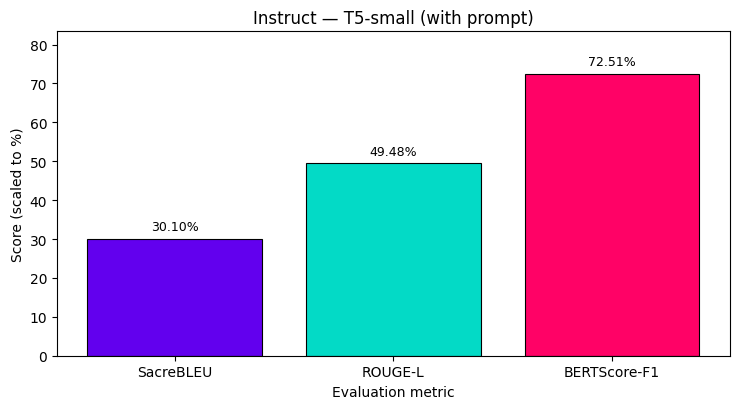

Evaluation numbers for Instruct — T5-small (with prompt): 
SacreBLEU        : 30.10
ROUGE-L (F1)     : 0.4948
BERTScore F1     : 0.7251


In [ ]:
# evaluation Instruct — T5-small (with prompt)
m_base = run_eval(
    "t5-small-e2e_nlg-test-results-3epoch-instruct.json",
    title="Instruct — T5-small (with prompt)",
    plot=True
)


# 7) Comparative Analysis

Evaluation numbers for Instruct — T5-small (without prompt): 
SacreBLEU        : 29.61
ROUGE-L (F1)     : 0.4967
BERTScore F1     : 0.7247
Evaluation numbers for Instruct — T5-small (with prompt): 
SacreBLEU        : 30.10
ROUGE-L (F1)     : 0.4948
BERTScore F1     : 0.7251


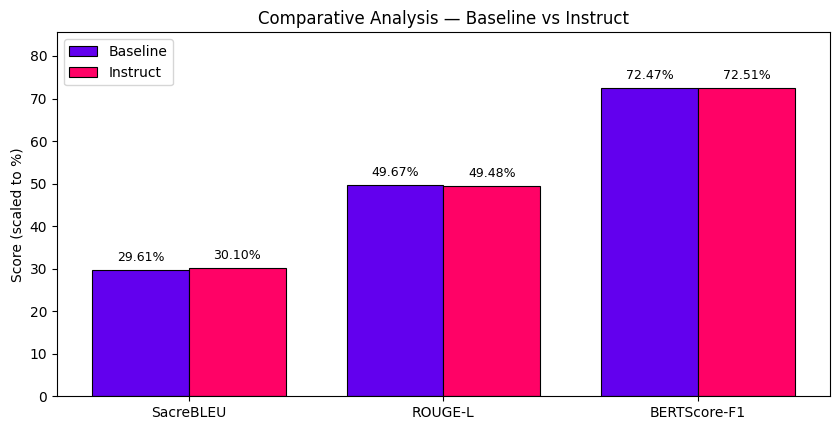

In [ ]:
# Comparative Analysis

# compute metrics for with and without prompt finetuned models
base_metrics = run_eval("t5-small-e2e_nlg-test-results-3epoch.json",
                        title="Instruct — T5-small (without prompt)", plot=False)
inst_metrics = run_eval("t5-small-e2e_nlg-test-results-3epoch-instruct.json",
                        title="Instruct — T5-small (with prompt)", plot=False)

# colors for visual
md_colors = ["#6200EE", "#03DAC6", "#FF0266", "#FFB300", "#018786", "#2962FF", "#00C853", "#AA00FF"]

# order + values
metrics_order = ["SacreBLEU", "ROUGE-L", "BERTScore-F1"]
base_vals = [base_metrics[m] for m in metrics_order]
inst_vals = [inst_metrics[m] for m in metrics_order]

# plot
import matplotlib.pyplot as plt
x = range(len(metrics_order)); w = 0.38
plt.figure(figsize=(8.5, 4.4))
ax = plt.gca()

bars1 = ax.bar([i - w/2 for i in x], base_vals, width=w, label="Baseline",
               color=md_colors[0], edgecolor="black", linewidth=0.8)
bars2 = ax.bar([i + w/2 for i in x], inst_vals, width=w, label="Instruct",
               color=md_colors[2], edgecolor="black", linewidth=0.8)

ax.set_xticks(list(x)); ax.set_xticklabels(metrics_order)
ax.set_ylabel("Score (scaled to %)"); ax.set_title("Comparative Analysis — Baseline vs Instruct")
ax.legend()

ymax = max(base_vals + inst_vals) if (base_vals + inst_vals) else 1
ax.set_ylim(0, max(5, ymax*1.18))

# data labels
for bars in (bars1, bars2):
    for b in bars:
        h = b.get_height()
        ax.text(b.get_x()+b.get_width()/2, h + ymax*0.02, f"{h:.2f}%",
                ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()
